** UPDATES: **
1. add /data folder
2. Base_model[ridge] w/o cv and hyperparameter tuning -- LEADERBOARD SCORE: 14875.25585 (local : 14458.693612)
3. Added model blending -- Top 2%- LEADERBOARD SCORE: 13258.78724

In [1]:
#load basic packages
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Function for creating model pipelines
from sklearn.pipeline import make_pipeline
# For standardization
from sklearn.preprocessing import StandardScaler
#from sklearn.compose import TransformedTargetRegressor
# Helper for cross-validation
from sklearn.model_selection import GridSearchCV
# Function for splitting training and test set
from sklearn.model_selection import train_test_split
# Import model algorithms
from sklearn.linear_model import ElasticNet, Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
# Import r2_score and mean_absolute_error functions
from sklearn.metrics import r2_score, mean_absolute_error
# Getting rid of annoying warnings
import warnings 
warnings.filterwarnings('ignore')

## Exploratory Data Analysis

  **1. GETTING THE DATA**


In [2]:
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data/test.csv
data/data_description.txt
data/train.csv
data/sample_submission.csv


* Here we read the training and test data and create and new dataframe with combined rows of train and test data
* We get the basic informations such as number of samples, shape of the data frames, column names.

In [3]:
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set 
    return pd.concat([train_data, test_data], sort=True)

# Read the data
df_train = pd.read_csv('data/train.csv', index_col='Id')
df_test = pd.read_csv('data/test.csv', index_col='Id')
df_all = concat_df(df_train, df_test)

df_train.name = 'Training Set'
df_test.name = 'Test Set'
df_all.name = 'All Set' 

dfs = [df_train, df_test]

print('Number of Training samples = {}'.format(df_train.shape[0]))
print('Number of Test samples = {}\n'.format(df_test.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}\n'.format(df_train['SalePrice'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}\n'.format(df_test.shape[0]))
print(df_train.columns)
print(df_test.columns)

Number of Training samples = 1460
Number of Test samples = 1459

Training X Shape = (1460, 80)
Training y Shape = 1460

Test X Shape = (1459, 79)
Test y Shape = 1459

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functio

* Next we look at how the data actually looks like

In [4]:
df_all.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
1,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
2,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
3,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
4,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
5,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


In [5]:
df_train.tail()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


In [6]:
df_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


 **2. DISTRIBUTIONS OF NUMERICAL FEATURES** 

We begin by plotting the distribution of the target variable SalePrice

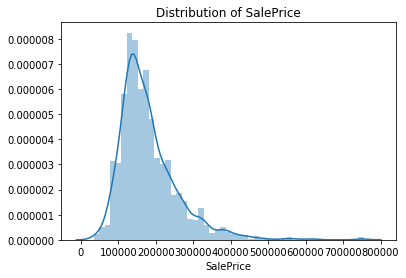

In [7]:
# Plotting the distribution of SalePrice
plt.figure()
sns.distplot(df_train.SalePrice)
plt.title('Distribution of SalePrice')
plt.show()

**Observation: It is clear from the graph that our target variable is skewed right (positive skew)!**

**Possible Actions to take: We can try to Logarithmic transform the SalePrice column to remove skew**



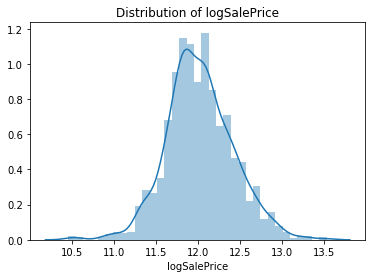

In [8]:
df_train['logSalePrice'] = np.log(df_train['SalePrice'])
# Plotting the distribution of lgSalePrice
plt.figure()
sns.distplot(df_train.logSalePrice)
plt.title('Distribution of logSalePrice')
plt.show()

Next we plot all the distributions all other numerical features

In [9]:
# create a new dataframe with columns containing only the numerical features
num_features = df_train.select_dtypes(exclude='object').drop('SalePrice', axis=1).copy()

# # we plot individual column distributions with null entry rows dropped
# fig, axs = plt.subplots(10, 4, figsize=(20, 20))
# for i in range(len(num_features.columns)):
#     plt.subplot(10, 4, i+1)
#     sns.distplot(num_features.iloc[:,i].dropna())
#     plt.xlabel(num_features.columns[i])

# plt.tight_layout()
# plt.show()

In [10]:
print(num_features.describe())

        MSSubClass  LotFrontage        LotArea  OverallQual  OverallCond  \
count  1460.000000  1201.000000    1460.000000  1460.000000  1460.000000   
mean     56.897260    70.049958   10516.828082     6.099315     5.575342   
std      42.300571    24.284752    9981.264932     1.382997     1.112799   
min      20.000000    21.000000    1300.000000     1.000000     1.000000   
25%      20.000000    59.000000    7553.500000     5.000000     5.000000   
50%      50.000000    69.000000    9478.500000     6.000000     5.000000   
75%      70.000000    80.000000   11601.500000     7.000000     6.000000   
max     190.000000   313.000000  215245.000000    10.000000     9.000000   

         YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1   BsmtFinSF2  ...  \
count  1460.000000   1460.000000  1452.000000  1460.000000  1460.000000  ...   
mean   1971.267808   1984.865753   103.685262   443.639726    46.549315  ...   
std      30.202904     20.645407   181.066207   456.098091   161.319273  ..

**3. DISTRIBUTIONS OF CATEGORICAL FEATURES**

* Let's take a look at basic informations for the categorical columns

In [11]:
# Summarize categorical features
df_train.describe(include=['object'])

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


* Now we produce a count plot for each categorical features. This will help us see the distributions of values in each category

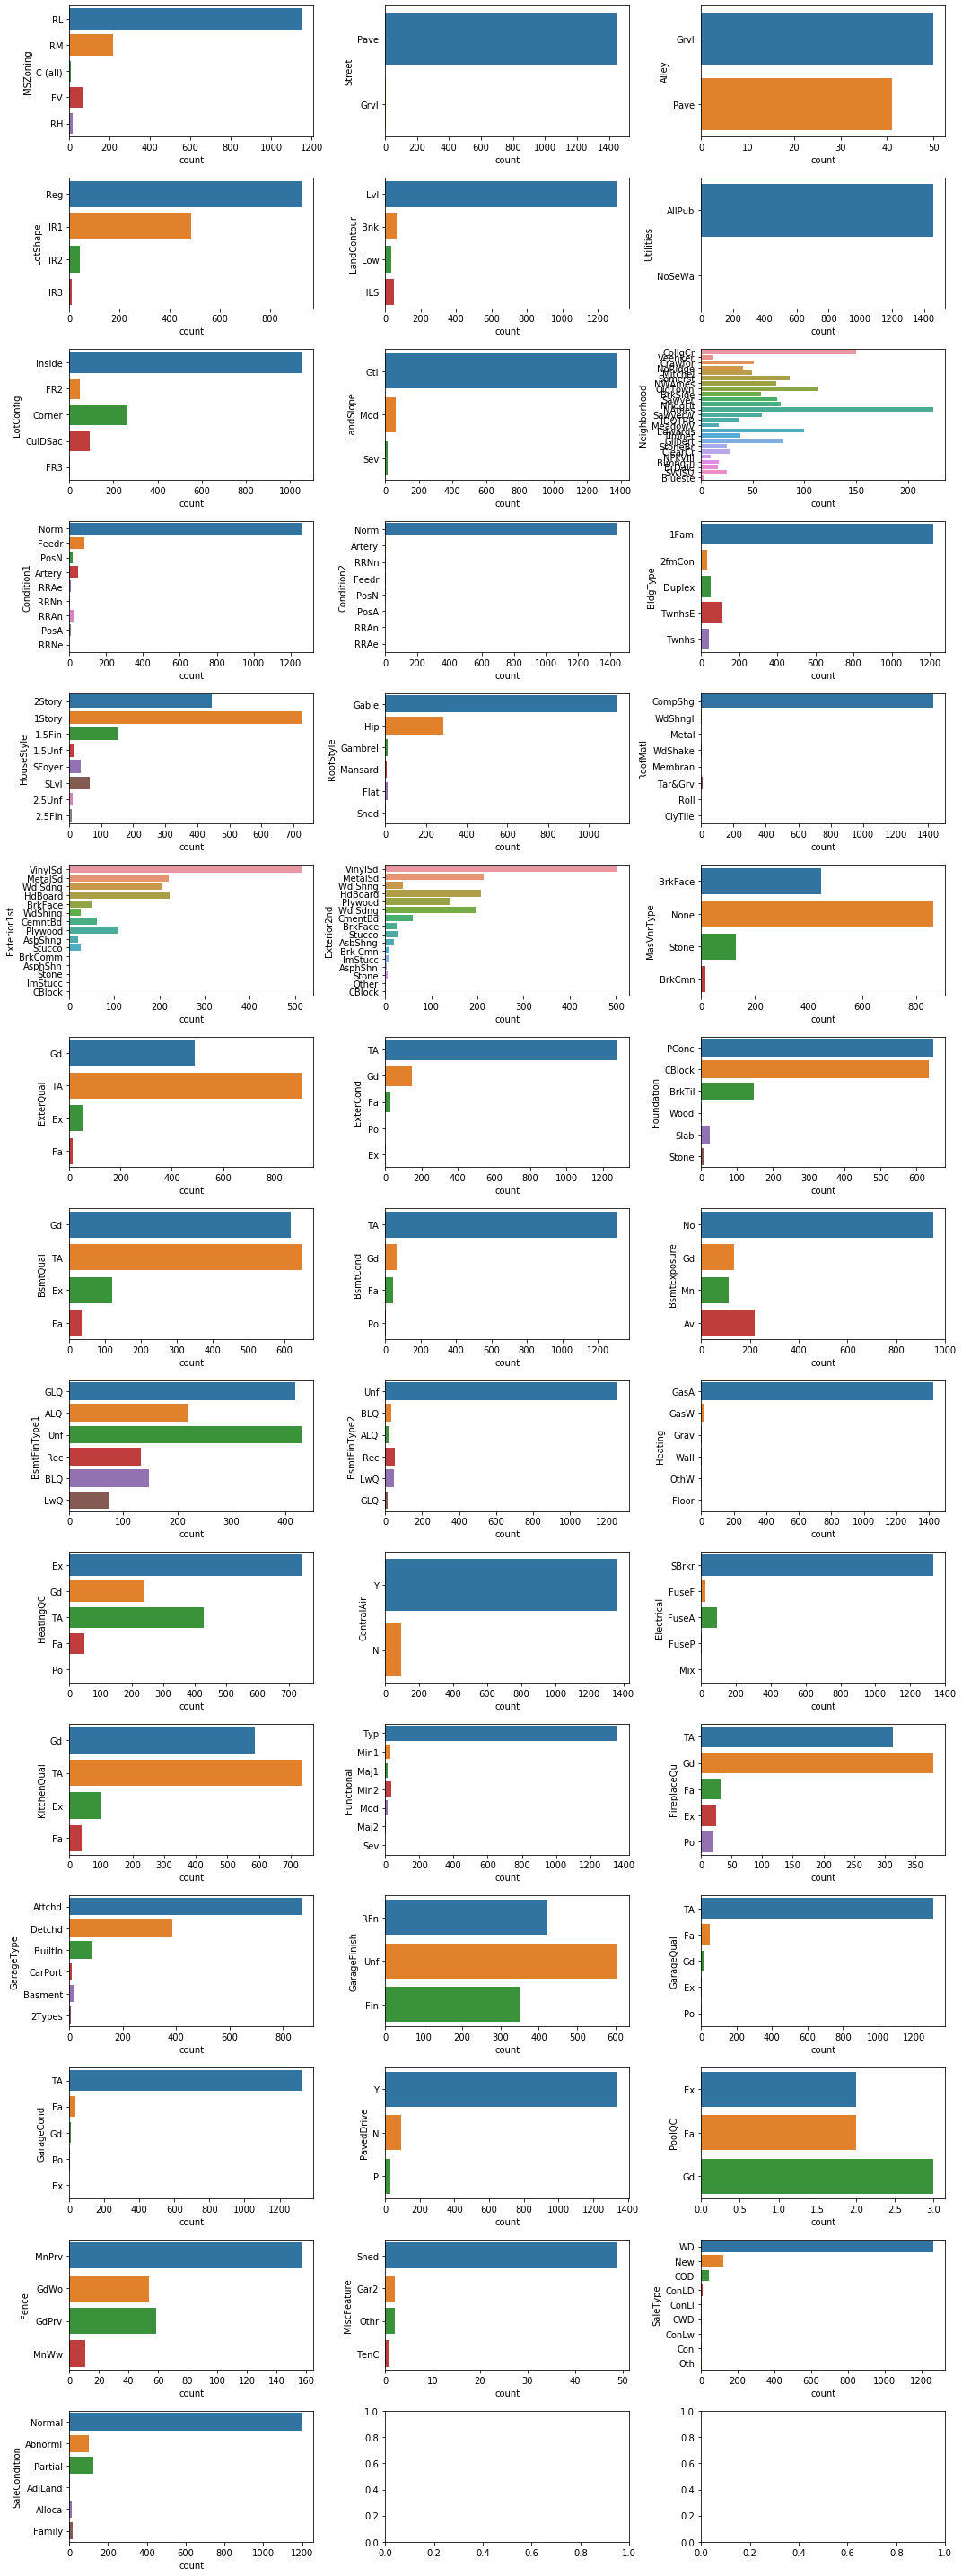

In [12]:
# create a new dataframe with columns containing only the categorical features
cat_features = df_train.select_dtypes(include='object').copy()

# we plot individual column distributions with null entry rows dropped
fig, axs = plt.subplots(nrows=15, ncols=3, figsize=(15, 40))
plt.subplots_adjust(right=1.5, top=1.25)

for i in range(len(cat_features.columns)):
    plt.subplot(15, 3, i+1)
    sns.countplot(y=cat_features.columns[i], data=cat_features)
    
plt.tight_layout()
plt.show()


**4. SEGMENTATIONS**

Here we try to see some connections/ relationships between categorical features and numerical features

In [13]:
# print out column names as a reminder
cat_features.columns, num_features.columns

(Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
        'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
        'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
        'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
        'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
        'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
        'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
        'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
        'SaleType', 'SaleCondition'],
       dtype='object'),
 Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
        'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
        'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
        'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
        'Bedro

* Let us check 'HouseStyle' and 'SalePrice'

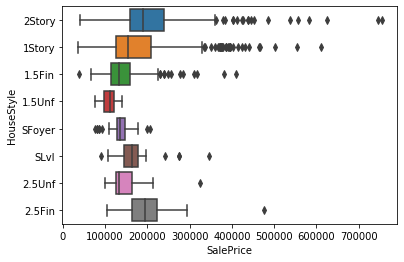

In [14]:
# Segment SalePrice by HouseStyle and plot distributions
sns.boxplot(y='HouseStyle', x='SalePrice', data=df_train)

> We see there is a considerable amout of outliers for 2Story, 1Story, and 1.5Fin type houses. Grouping the dataframe as below we see which HouseStyle are more expensive in average

In [15]:
df_train.groupby('HouseStyle')['SalePrice'].mean().sort_values(ascending=False)

HouseStyle
2.5Fin    220000.000000
2Story    210051.764045
1Story    175985.477961
SLvl      166703.384615
2.5Unf    157354.545455
1.5Fin    143116.740260
SFoyer    135074.486486
1.5Unf    110150.000000
Name: SalePrice, dtype: float64

In [16]:
# Segment by property_type and display the means and standard deviations within each class
df_train.groupby('HouseStyle').agg([np.mean,np.std])

MSSubClass            LotFrontage                  LotArea  \
                  mean        std        mean        std          mean   
HouseStyle                                                               
1.5Fin       58.181818  31.652826   63.830882  17.542142  11448.623377   
1.5Unf       54.285714  39.265229   54.615385   4.011202   7118.714286   
1Story       37.079890  36.615606   71.822742  22.538826  10644.409091   
2.5Fin       88.750000  40.948574   78.750000  16.756662  12468.125000   
2.5Unf       95.909091  46.519791   61.800000  14.109099   9153.272727   
2Story       79.179775  38.797395   70.350829  29.225100  10325.166292   
SFoyer      105.135135  37.127530   57.233333  23.061661   7672.837838   
SLvl         85.230769  26.345522   76.295455  19.868849  10537.738462   

                         OverallQual           OverallCond            ...  \
                     std        mean       std        mean       std  ...   
HouseStyle                                                            ...   
1.5Fin      17866.666291    5.402597  1.019544    5.980519  1.393124  ...   
1.5Unf       1825.769024    5.500000  0.854850    6.142857  1.167321  ...   
1Story      10231.399063    5.946281  1.485983    5.471074  1.054967  ...   
2.5Fin       6139.342041    6.375000  1.767767    6.750000  2.052873  ...   
2.5Unf       2264.804852    6.545455  1.368476    6.000000  1.341641  ...   
2Story       6433.772730    6.683146  1.187703    5.498876  1.021447  ...   
SFoyer       3555.136468    5.324324  0.944400    5.783784  1.157947  ...   
SLvl         3431.246281    5.923077  0.853443    5.846154  1.019049  ...   

               MiscVal                MoSold                 YrSold            \
                  mean         std      mean       std         mean       std   
HouseStyle                                                                      
1.5Fin      113.961039  712.275575  6.285714  2.545570  2007.837662  1.310943   
1.5Unf        0.000000    0.000000  5.857143  2.957575  2007.571429  0.937614   
1Story       44.440771  593.673519  6.278237  2.777693  2007.845730  1.339440   
2.5Fin        0.000000    0.000000  6.000000  2.203893  2007.625000  1.187735   
2.5Unf        0.000000    0.000000  6.818182  3.219260  2007.454545  1.035725   
2Story       25.797753  231.228806  6.370787  2.597565  2007.782022  1.332085   
SFoyer       27.027027  117.020057  6.135135  2.945450  2007.891892  1.429526   
SLvl         18.461538  105.907253  6.723077  2.792332  2007.753846  1.323239   

                SalePrice                logSalePrice            
                     mean            std         mean       std  
HouseStyle                                                       
1.5Fin      143116.740260   54277.941119    11.813528  0.332167  
1.5Unf      110150.000000   19036.473090    11.595027  0.179639  
1Story      175985.477961   77055.715011    11.993683  0.408708  
2.5Fin      220000.000000  118211.976671    12.194451  0.480150  
2.5Unf      157354.545455   63934.128032    11.908751  0.334750  
2Story      210051.764045   87339.213570    12.182686  0.376981  
SFoyer      135074.486486   30480.898192    11.786479  0.242975  
SLvl        166703.384615   38305.161339    12.002153  0.204158  

[8 rows x 76 columns]

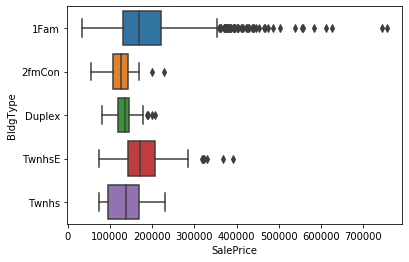

In [17]:
sns.boxplot(y='BldgType', x='SalePrice', data=df_train)

**5. CORRELATIONS**

Finally we look at the relationships between numeric features and other numeric features.

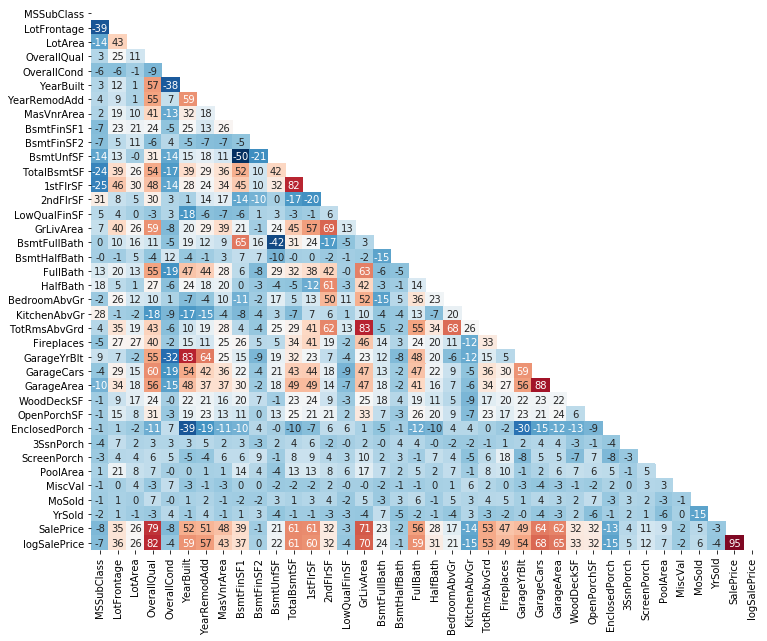

In [18]:
# Get correlation 
correlations = df_train.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Make the figsize 10 x 8
plt.figure(figsize=(12,10))

# Plot heatmap of correlations
sns.heatmap(correlations*100, cmap='RdBu_r' , annot=True, fmt='.0f', mask=mask, cbar=False,)

> Below we make a list of features with low (near zero) and negative correlations to SalePrice. Later we will consider the effect of drop these features on our base model

In [19]:
low_corr = ['PoolArea', 'MoSold', '3SsnPorch', 'BsmtFinSF2', 
            'BsmtFinSF2', 'BsmtHalfBath', 'MiscVal',
            'LowQualFinSF', 'YrSold', 'OverallCond', 
            'MSSubClass', 'EnclosedPorch', 'KitchenAbvGr']

> We will also make a list of features which simultaneously has high correlation with both SalePrice and other features:

* GrLivArea and TotRmsAbvGrd
* GarageCars and GarageArea 
* YearBuilt and GarageYrBlt 
* TotalBsmtSF and 1stFlrSF

>We will choose only one for each pair

In [20]:
mult_corr = ['1stFlrSF', 'GarageArea', 'GarageYrBlt', 'TotRmsAbvGrd']

For now, let us leave EDA like this and move on to data cleaning

## Data Cleaning

**Note: From here we simultaneously clean both train and test data**

Using our combined dataframe **df_all** should make this process quicker

**1. Drop unwanted observations**

In [21]:
print('DataFrame shape BEFORE dropping duplicates: {}'.format(df_all.shape))
df_all = df_all.drop_duplicates()
print('DataFrame shape AFTER dropping duplicates: {}'.format(df_all.shape))

DataFrame shape BEFORE dropping duplicates: (2919, 80)
DataFrame shape AFTER dropping duplicates: (2919, 80)


**2. Remove unwanted outliers**

> Using a scatter plot helps us easily identify columns with outstanding outliers

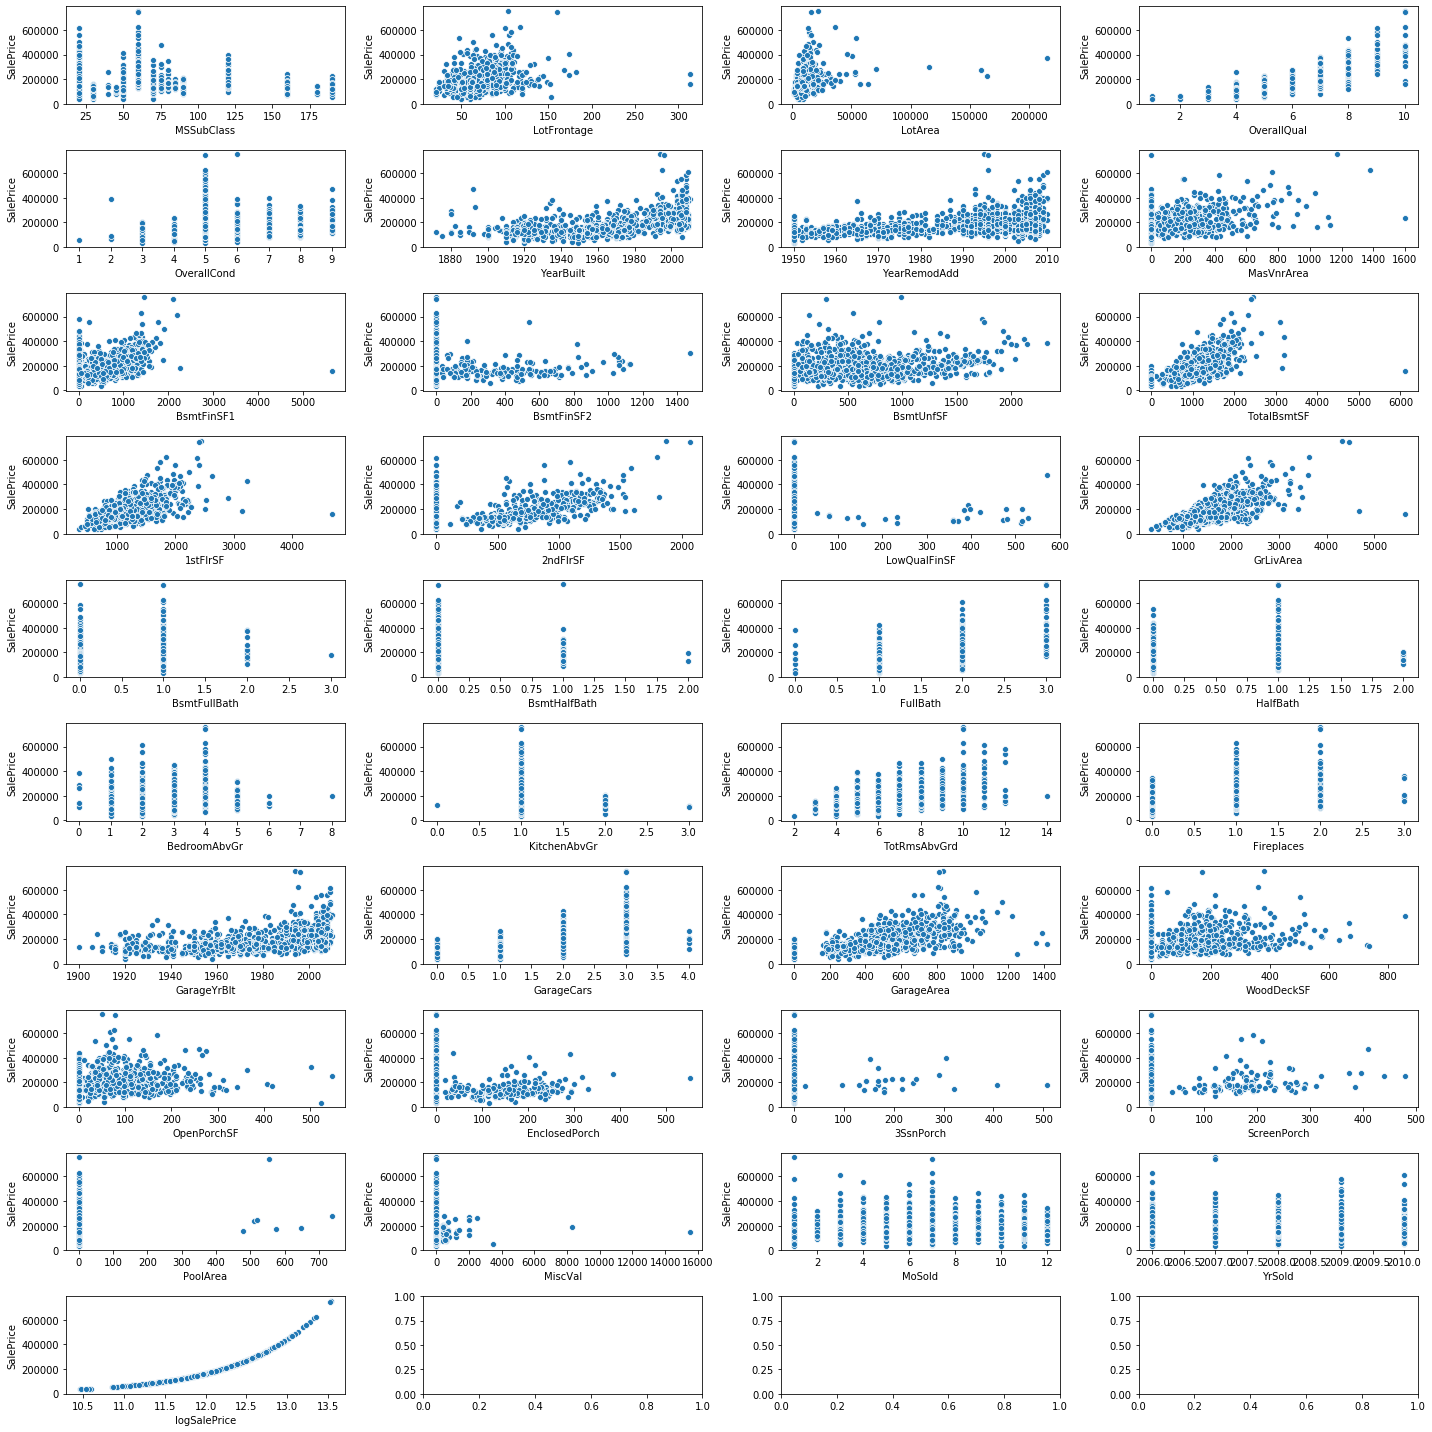

In [22]:
# We build a scatter for each numerical column feature vs our target
fig, axs = plt.subplots(10, 4, figsize=(20, 20))
for i in range(len(num_features.columns)):
    plt.subplot(10, 4, i+1)
    sns.scatterplot(num_features.iloc[:,i].dropna(), df_train.SalePrice)
    plt.xlabel(num_features.columns[i])

plt.tight_layout()
plt.show()

**Observations: We list some outstanding outliers**

* LotFrontage >200 and SalePrice <300000
* LotArea >100000 and SalePrice <400000
* BsmtFinSF1 >3000 and SalePrice <300000
* TotalBsmtSF >4000 and SalePrice <300000
* 1stFlrSF >4000
* GrLivArea >4000 AND SalePrice <300000
* LowQualFinSF >550

Let us prepare the mask to remove outliers. We will use them later to see how applying masks affect our predictions

In [23]:
mask_1 = (df_train.LotFrontage >200) & (df_train.SalePrice <300000)
mask_2 = (df_train.LotArea >100000) & (df_train.SalePrice <400000)
mask_3 = (df_train.BsmtFinSF1 >3000) & (df_train.SalePrice <300000)
mask_4 = (df_train.TotalBsmtSF >4000) & (df_train.SalePrice <300000)
mask_5 = df_train['1stFlrSF'] >4000
mask_6 = (df_train.GrLivArea >4000) & (df_train.SalePrice <300000)
mask_7 = df_train.LowQualFinSF >550

#make a dictionary of our masks
masks = {'LotFrontage': mask_1, 'LotArea': mask_2, 'BsmtFinSF1': mask_3,
         'TotalBsmtSF': mask_4, '1stFlrSF': mask_5,
         'GrLivArea': mask_6, 'LowQualFinSF': mask_7}

In [24]:
# We run a for-loop using our dictionary to remove outliers
for cols, mask in masks.items():
    df_train.drop(df_train[cols][mask].index, inplace=True)
    
df_train.shape, df_train.columns

((1452, 81),
 Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
        'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
        'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
        'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
        'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
        'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
        'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
        'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
        'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
        'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
        'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
        'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
        'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond'

**3. Identify missing values**

We define a function below and run a for-loop to print information about missing values in both train and test data

In [25]:
def display_missing(df):    
    for col in df.columns.tolist():          
        print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')
    
for df in dfs:
    print('{}'.format(df.name))
    display_missing(df)

Training Set
MSSubClass column missing values: 0
MSZoning column missing values: 0
LotFrontage column missing values: 256
LotArea column missing values: 0
Street column missing values: 0
Alley column missing values: 1361
LotShape column missing values: 0
LandContour column missing values: 0
Utilities column missing values: 0
LotConfig column missing values: 0
LandSlope column missing values: 0
Neighborhood column missing values: 0
Condition1 column missing values: 0
Condition2 column missing values: 0
BldgType column missing values: 0
HouseStyle column missing values: 0
OverallQual column missing values: 0
OverallCond column missing values: 0
YearBuilt column missing values: 0
YearRemodAdd column missing values: 0
RoofStyle column missing values: 0
RoofMatl column missing values: 0
Exterior1st column missing values: 0
Exterior2nd column missing values: 0
MasVnrType column missing values: 8
MasVnrArea column missing values: 8
ExterQual column missing values: 0
ExterCond column missing v

**3.1 Label missing categorical data**

In [26]:
# Display number of missing values by feature (categorical)
df_all.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False).head(25)

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
FireplaceQu     1420
GarageCond       159
GarageFinish     159
GarageQual       159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MSZoning           4
Functional         2
Utilities          2
Exterior1st        1
KitchenQual        1
Electrical         1
SaleType           1
Exterior2nd        1
CentralAir         0
Condition1         0
dtype: int64

In [27]:
# Fill missing categorical values
for column in df_all.select_dtypes(include=['object']).columns.tolist():
    df_all[column] = df_all[column].fillna('Missing')

# Display number of missing values by feature (categorical)
df_all.select_dtypes(include=['object']).isnull().sum()

Alley            0
BldgType         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinType2     0
BsmtQual         0
CentralAir       0
Condition1       0
Condition2       0
Electrical       0
ExterCond        0
ExterQual        0
Exterior1st      0
Exterior2nd      0
Fence            0
FireplaceQu      0
Foundation       0
Functional       0
GarageCond       0
GarageFinish     0
GarageQual       0
GarageType       0
Heating          0
HeatingQC        0
HouseStyle       0
KitchenQual      0
LandContour      0
LandSlope        0
LotConfig        0
LotShape         0
MSZoning         0
MasVnrType       0
MiscFeature      0
Neighborhood     0
PavedDrive       0
PoolQC           0
RoofMatl         0
RoofStyle        0
SaleCondition    0
SaleType         0
Street           0
Utilities        0
dtype: int64

> PERFECT! Now all categorical data are non-empty!

**3.2 Identify and fill missing numerical data**

In [28]:
# Display number of missing values by feature (numeric)
df_all.drop('SalePrice', axis=1).select_dtypes(exclude=['object']).isnull().sum().sort_values(ascending=False).head(12)

LotFrontage     486
GarageYrBlt     159
MasVnrArea       23
BsmtFullBath      2
BsmtHalfBath      2
BsmtFinSF1        1
BsmtFinSF2        1
TotalBsmtSF       1
BsmtUnfSF         1
GarageArea        1
GarageCars        1
BedroomAbvGr      0
dtype: int64

> Aside from GarageYrBlt, it seems it is reasonable to fill missing data with the mean of each feature columns. Moreover, we will drop GarageYrBlt as mentioned in our correlation stage so pd.fillna on it does not matter. It would help to look back at our previous scatter plots

In [29]:
# Fill missing numerical values
for column in df_all.drop('SalePrice', axis=1).select_dtypes(exclude=['object']).columns.tolist():
    df_all[column] = df_all[column].fillna(df_all[column].mean())

# Display number of missing values by feature (categorical)
df_all.drop('SalePrice', axis=1).select_dtypes(exclude=['object']).isnull().sum()

1stFlrSF         0
2ndFlrSF         0
3SsnPorch        0
BedroomAbvGr     0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtFullBath     0
BsmtHalfBath     0
BsmtUnfSF        0
EnclosedPorch    0
Fireplaces       0
FullBath         0
GarageArea       0
GarageCars       0
GarageYrBlt      0
GrLivArea        0
HalfBath         0
KitchenAbvGr     0
LotArea          0
LotFrontage      0
LowQualFinSF     0
MSSubClass       0
MasVnrArea       0
MiscVal          0
MoSold           0
OpenPorchSF      0
OverallCond      0
OverallQual      0
PoolArea         0
ScreenPorch      0
TotRmsAbvGrd     0
TotalBsmtSF      0
WoodDeckSF       0
YearBuilt        0
YearRemodAdd     0
YrSold           0
dtype: int64

**4. Identifying label inconsistencies**

We will only use column features which has the same set of labels for both train and test set

In [30]:
# All categorical columns
object_cols = [col for col in df_train.columns if df_train[col].dtype == "object"]

# Columns that can be safely label encoded
good_label_cols = [col for col in object_cols if 
                   set(df_train[col]) == set(df_test[col])]
        
# Problematic columns that will be dropped from the dataset
bad_label_cols = list(set(object_cols)-set(good_label_cols))
        
print('Categorical columns with consistent labels:', good_label_cols)
print('\nCategorical columns with inconsistent labels:', bad_label_cols)

Categorical columns with consistent labels: ['Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'RoofStyle', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCond', 'PavedDrive', 'Fence', 'SaleCondition']

Categorical columns with inconsistent labels: ['Functional', 'Heating', 'GarageQual', 'RoofMatl', 'HouseStyle', 'Exterior1st', 'Electrical', 'PoolQC', 'MSZoning', 'SaleType', 'Condition2', 'Exterior2nd', 'MiscFeature', 'KitchenQual', 'Utilities']


> Now we will collect a list of features we wish to drop

In [31]:
# Collect some features to drop. This is an iterative process
drop_features = list(set(mult_corr) )
drop_features
# set(low_corr) or or set(bad_label_cols)

['1stFlrSF', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea']

>Let's save our hard work!

In [32]:
# Save cleaned dataframe to new file
df_all.to_csv('cleaned_df.csv', index=None)

## Feature Engineering

**1. Create interaction features**

This can be done by doing some algebraic manipulations between a number of numerical columns.


In [33]:
# Add the new feature of TotalArea adding basement,1st and 2nd floor area
df_all['TotalArea'] = df_all[['TotalBsmtSF', '1stFlrSF', '2ndFlrSF']].sum(axis=1)

In [34]:
# Next we add a GardenArea feature
df_all['GardenArea'] = df_all['LotArea'] - df_all['1stFlrSF']

In [35]:
# Generate total bathroom
df_all['TotalBathroom'] = df_all['FullBath'] + df_all['HalfBath']

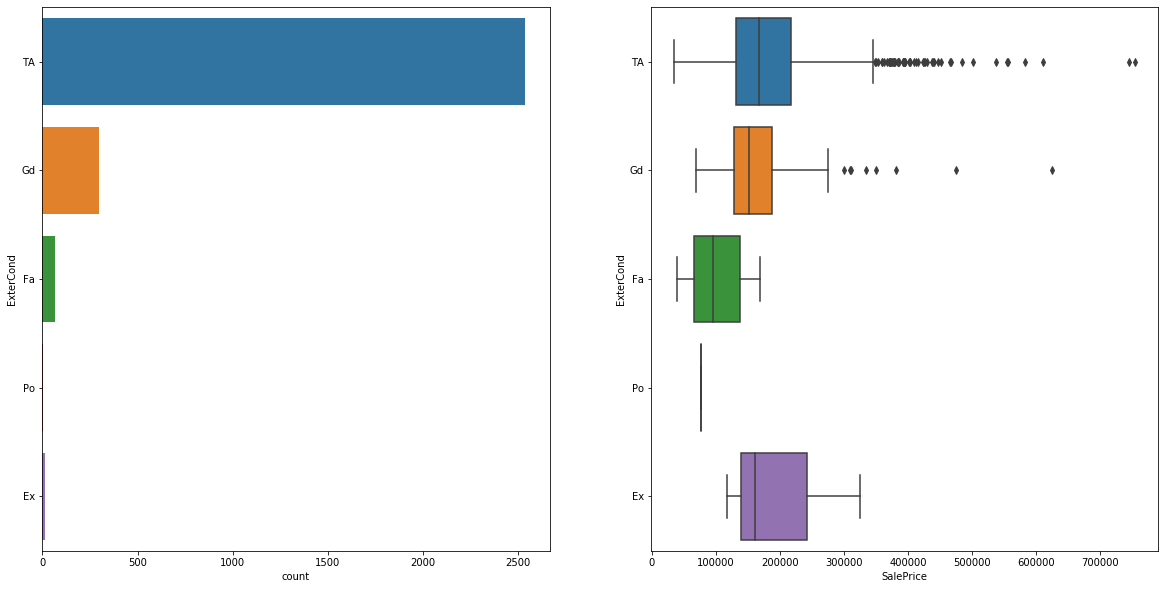

In [36]:

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

plt.subplot(1,2,1)
sns.countplot(y=df_all['ExterCond'])

plt.subplot(1,2,2)
sns.boxplot(y='ExterCond', x='SalePrice', data=df_all)

In [37]:
df_all['ExterCond'].replace('Po', 'Ex', inplace=True)

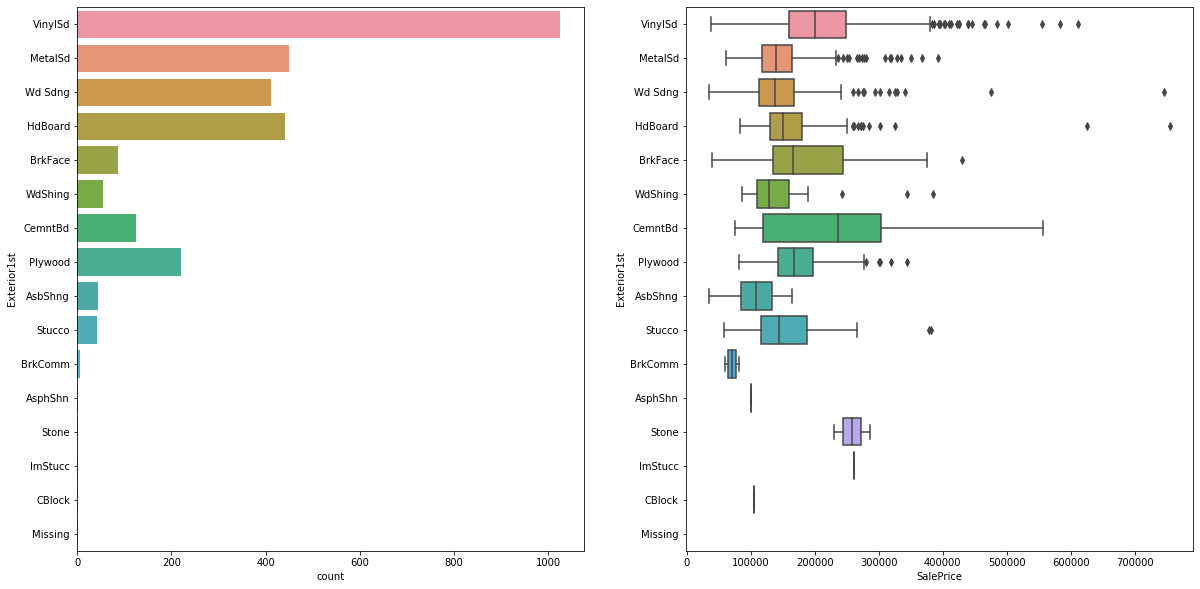

In [38]:
# Doing some plots below to understand how to group Exterior feature
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

plt.subplot(1,2,1)
sns.countplot(y= df_all['Exterior1st'])

plt.subplot(1,2,2)
sns.boxplot(y='Exterior1st', x='SalePrice', data=df_all)

> Considering these two plots, I plan to group Exterior by price range. (med, hi)

In [39]:
df_all['Exterior1st'].unique(),df_train['Exterior1st'].unique(),df_test['Exterior1st'].unique()

(array(['VinylSd', 'MetalSd', 'Wd Sdng', 'HdBoard', 'BrkFace', 'WdShing',
        'CemntBd', 'Plywood', 'AsbShng', 'Stucco', 'BrkComm', 'AsphShn',
        'Stone', 'ImStucc', 'CBlock', 'Missing'], dtype=object),
 array(['VinylSd', 'MetalSd', 'Wd Sdng', 'HdBoard', 'BrkFace', 'WdShing',
        'CemntBd', 'Plywood', 'AsbShng', 'Stucco', 'BrkComm', 'AsphShn',
        'Stone', 'ImStucc', 'CBlock'], dtype=object),
 array(['VinylSd', 'Wd Sdng', 'HdBoard', 'Plywood', 'MetalSd', 'CemntBd',
        'WdShing', 'BrkFace', 'AsbShng', 'BrkComm', 'Stucco', 'AsphShn',
        nan, 'CBlock'], dtype=object))

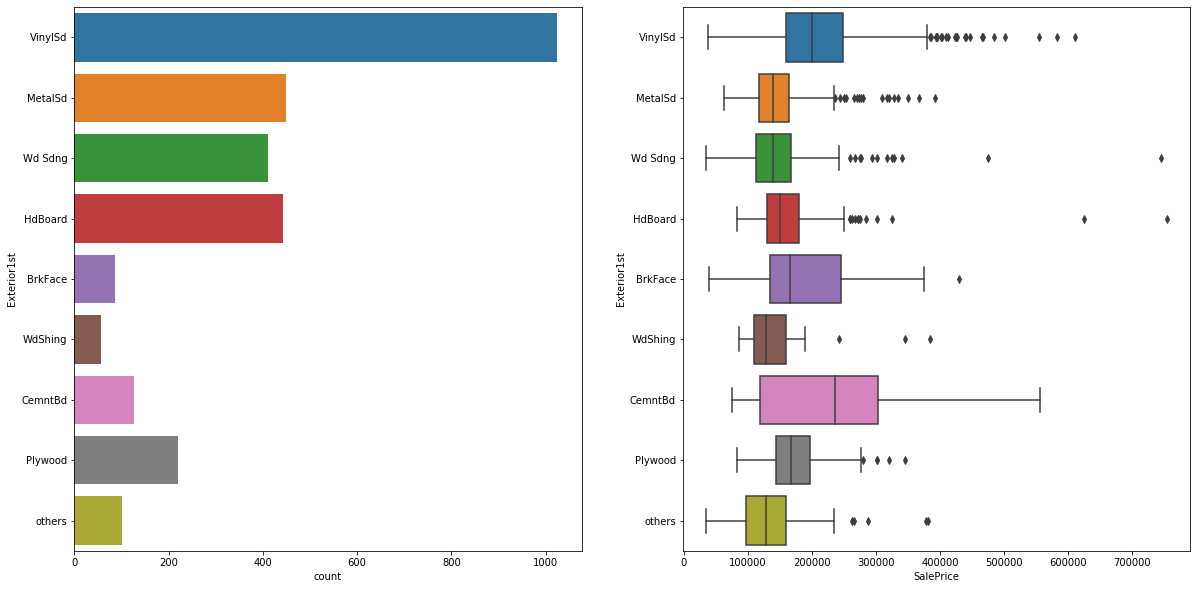

In [40]:
# Group exteriors with SalePrice range 100k to 200k as 'med'
#df_all['Exterior1st'].replace(['Wd Sdng', 'HdBoard', 'WdShing',        'Plywood'],'wood', inplace=True)

# Group SalePrice range > 200k into 'hi'
df_all['Exterior1st'].replace(['AsbShng', 'Stucco', 'BrkComm', 'AsphShn',
         'ImStucc', 'CBlock', 'Missing', 'Stone'], 'others', inplace=True)

#Now let us see the changes

# Doing some plots below to understand how to group Exterior feature
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

plt.subplot(1,2,1)
sns.countplot(y= df_all['Exterior1st'])

plt.subplot(1,2,2)
sns.boxplot(y='Exterior1st', x='SalePrice', data=df_all)

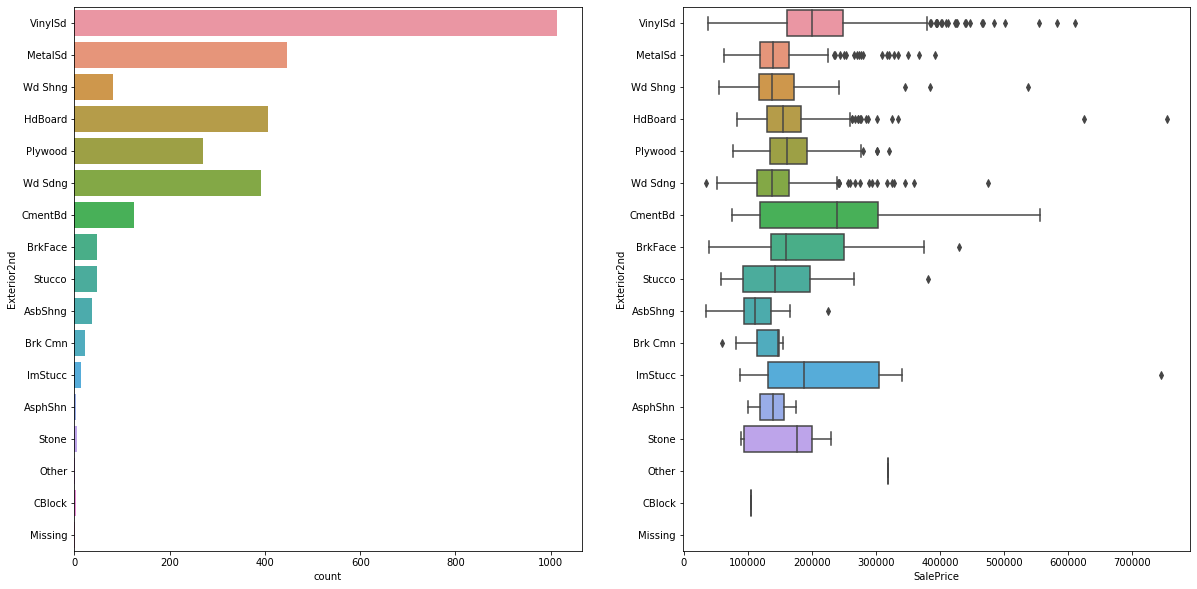

In [41]:
# Doing some plots below to understand how to group Exterior2nd feature
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

plt.subplot(1,2,1)
sns.countplot(y= df_all['Exterior2nd'])

plt.subplot(1,2,2)
sns.boxplot(y='Exterior2nd', x='SalePrice', data=df_all)

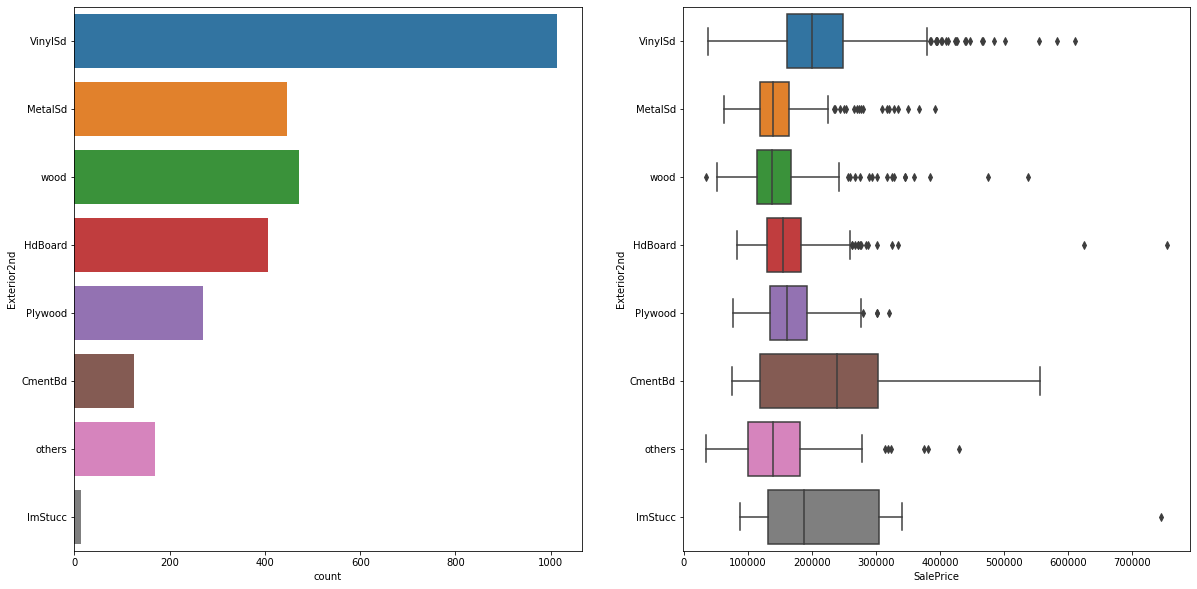

In [42]:
# Group exteriors with SalePrice range 100k to 200k as 'med'
df_all['Exterior2nd'].replace(['Wd Shng', 'Wd Sdng'],'wood', inplace=True)

# Group SalePrice range > 200k into 'hi'
df_all['Exterior2nd'].replace(['BrkFace', 'Stucco', 'AsbShng', 'Brk Cmn',
        'AsphShn', 'Stone', 'Other', 'CBlock', 'Missing'], 'others', inplace=True)

# See the changes
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

plt.subplot(1,2,1)
sns.countplot(y= df_all['Exterior2nd'])

plt.subplot(1,2,2)
sns.boxplot(y='Exterior2nd', x='SalePrice', data=df_all)

(array([nan, 'Ex', 'Fa', 'Gd'], dtype=object),
 array([nan, 'Ex', 'Gd'], dtype=object))

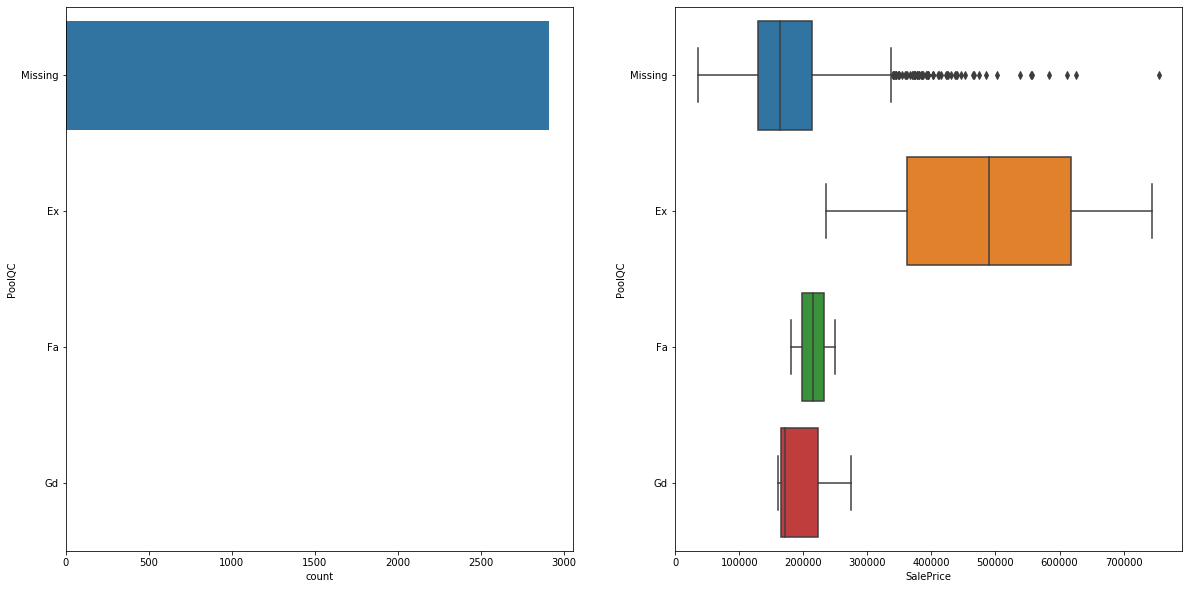

In [43]:
# Doing some plots below to understand how to group Exterior feature
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

plt.subplot(1,2,1)
sns.countplot(y= df_all['PoolQC'])

plt.subplot(1,2,2)
sns.boxplot(y='PoolQC', x='SalePrice', data=df_all)

df_train.PoolQC.unique(), df_test.PoolQC.unique()

In [44]:
df_all['PoolQC'].replace(['Fa'],'Gd', inplace=True)

In [45]:
# Create a property age feature
df_all['property_age'] = df_all.YrSold - df_all.YearBuilt
df_all['property_age']>0 # check that are no negative ages!

Id
1       True
2       True
3       True
4       True
5       True
        ... 
2915    True
2916    True
2917    True
2918    True
2919    True
Name: property_age, Length: 2919, dtype: bool

> **Now let us separate our df_all dataframe back to df_test and df_train**

In [46]:
# Split back into train and test
clean_train = df_all[df_all.index.isin(df_train.index)]
clean_test = df_all[df_all.index.isin(df_test.index)]

In [47]:
#checking that we fixed the bad labels
clean_train['PoolQC'].unique(),clean_test['PoolQC'].unique()

(array(['Missing', 'Ex', 'Gd'], dtype=object),
 array(['Missing', 'Ex', 'Gd'], dtype=object))

In [48]:
#checking that we fixed the bad labels of Exterior1st
clean_train['Exterior1st'].unique(),clean_test['Exterior1st'].unique()

(array(['VinylSd', 'MetalSd', 'Wd Sdng', 'HdBoard', 'BrkFace', 'WdShing',
        'CemntBd', 'Plywood', 'others'], dtype=object),
 array(['VinylSd', 'Wd Sdng', 'HdBoard', 'Plywood', 'MetalSd', 'CemntBd',
        'WdShing', 'BrkFace', 'others'], dtype=object))

In [49]:
#checking that we fixed the bad labels of Exterior2nd
clean_train['Exterior2nd'].unique(),clean_test['Exterior2nd'].unique()

(array(['VinylSd', 'MetalSd', 'wood', 'HdBoard', 'Plywood', 'CmentBd',
        'others', 'ImStucc'], dtype=object),
 array(['VinylSd', 'wood', 'HdBoard', 'Plywood', 'MetalSd', 'others',
        'CmentBd', 'ImStucc'], dtype=object))

In [50]:
clean_test['ExterCond'].unique(), clean_train['ExterCond'].unique(), 

(array(['TA', 'Gd', 'Fa', 'Ex'], dtype=object),
 array(['TA', 'Gd', 'Fa', 'Ex'], dtype=object))

> We look at the tail of train data and the head of test data for sanity check

> All good! Now let us start modelling!

## Machine learning models

**1. Split the dataset**

In [51]:
attributes_drop = [ 'logSalePrice', 'SalePrice',
                   'MiscVal', 'MSSubClass', 'MoSold', 'YrSold', 
                   'GarageArea', 'GarageYrBlt', 'TotRmsAbvGrd']
# add logSalePrice on clean_train
clean_train['logSalePrice'] = df_train['logSalePrice']

# Create separate object for target variable
y = clean_train.logSalePrice

# Create separate object for input features
X = pd.get_dummies(clean_train.drop(['SalePrice',  'logSalePrice', 'MoSold', 'YrSold',
                                     'KitchenQual', 'RoofMatl', 'Electrical', 'Utilities', 'GarageQual', 'MiscFeature', 'SaleType', 'Heating', 'HouseStyle', 'Condition2', 'Functional', 'MSZoning'], 
                                    axis = 1))

# Set the OneHot encoded clean test data as Test
Test = pd.get_dummies(clean_test.drop(['SalePrice', 'MoSold', 'YrSold',
                                     'KitchenQual', 'RoofMatl', 'Electrical', 'Utilities', 'GarageQual', 'MiscFeature', 'SaleType', 'Heating', 'HouseStyle', 'Condition2', 'Functional', 'MSZoning'], axis = 1))

# Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 505)

print( len(X_train), len(X_test), len(y_train), len(y_test) )

1161 291 1161 291


In [52]:
# Making sure we have the same number of columns for local test set and submission test set
X_test.columns, Test.columns

(Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1',
        'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
        'EnclosedPorch',
        ...
        'RoofStyle_Mansard', 'RoofStyle_Shed', 'SaleCondition_Abnorml',
        'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family',
        'SaleCondition_Normal', 'SaleCondition_Partial', 'Street_Grvl',
        'Street_Pave'],
       dtype='object', length=216),
 Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1',
        'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
        'EnclosedPorch',
        ...
        'RoofStyle_Mansard', 'RoofStyle_Shed', 'SaleCondition_Abnorml',
        'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family',
        'SaleCondition_Normal', 'SaleCondition_Partial', 'Street_Grvl',
        'Street_Pave'],
       dtype='object', length=216))

**2. Build base models and model pipelines**

> The reason for building several base models before doing hyperparameter tuning is that we can see easily record the effects of **feature engineering** through these base models then make changes accordingly.

In [53]:


# Create pipelines dictionary
pipelines =  {
            'lasso': make_pipeline(StandardScaler(), Lasso(random_state=505)),
            'ridge': make_pipeline(StandardScaler(), Ridge(random_state=505)),
            'enet': make_pipeline(StandardScaler(), ElasticNet(random_state=505)),
            'rf': make_pipeline(StandardScaler(), RandomForestRegressor(random_state=505)),
            'gb': make_pipeline(StandardScaler(), GradientBoostingRegressor(random_state=505 )),
            'xgb': make_pipeline(StandardScaler(), XGBRegressor(random_state=505 ))
                }                               

>Now it's time to fit the models to our training data then evaluate!

In [54]:


# Loop through model pipelines
for name, pipeline in pipelines.items():
  
    # Fit model on X_train, y_train  and predict with X_test
    pipeline.fit(X_train, y_train)
    pred = pipeline.predict(X_test)
    
    # Print '{name} has been fitted'
    print(name, 'has been fitted.')
    #print('R^2:', r2_score(y_test, pred))
    print('R^2:', r2_score(np.exp(y_test), np.exp(pred)))
    #print('MAE: ', mean_absolute_error(y_test, pred))
    print('MAE: ', mean_absolute_error(np.exp(y_test), np.exp(pred)))
    print('\n')    
    

lasso has been fitted.
R^2: -0.03215915680622561
MAE:  55020.51619739956


ridge has been fitted.
R^2: 0.9237519005486519
MAE:  14471.913364112845


enet has been fitted.
R^2: -0.03215915680622561
MAE:  55020.51619739956


rf has been fitted.
R^2: 0.8718353756515715
MAE:  18220.510285117332


gb has been fitted.
R^2: 0.8873457408261258
MAE:  16899.621382221034


[10:01:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xgb has been fitted.
R^2: 0.8910628727452082
MAE:  16927.586608676975




> Some notes: "R squared", is the proportion of the variance in the dependent variable that is predictable from the independent variable(s). The closer it is to 1 the better.

**3. Hyperparameter tuning**

List the tuneables parameters for each model. You can check this by yourself using .get_params()

In [55]:
pipelines['ridge'].get_params()

{'memory': None,
 'steps': [('standardscaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('ridge',
   Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
         normalize=False, random_state=505, solver='auto', tol=0.001))],
 'verbose': False,
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'ridge': Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
       normalize=False, random_state=505, solver='auto', tol=0.001),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'ridge__alpha': 1.0,
 'ridge__copy_X': True,
 'ridge__fit_intercept': True,
 'ridge__max_iter': None,
 'ridge__normalize': False,
 'ridge__random_state': 505,
 'ridge__solver': 'auto',
 'ridge__tol': 0.001}

In [56]:
# Create a dictionary for each models hyperparameters

lasso_hyparams = {'lasso__alpha':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10] }

ridge_hyparams = {'ridge__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10] }

enet_hyparams = {
    'elasticnet__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
    'elasticnet__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

rf_hyparams  = {
    'randomforestregressor__n_estimators': [100,200],
    'randomforestregressor__max_features': ['auto', 'sqrt', 0.33]
}

gb_hyparams = {
            'gradientboostingregressor__n_estimators' : [100,200],
            'gradientboostingregressor__learning_rate': [0.05, 0.1,0.2],
            'gradientboostingregressor__max_depth': [1,3,5]
}

xgb_hyparams =  {
    "xgbregressor__n_estimators":[500, 700],
    "xgbregressor__learning_rate":[0.01, 0.05],
    'xgbregressor__max_depth': [3,6],
 }



In [57]:
# Now create a dictionary of hyperparameter dictionaries !?

hyperparameters = {
    'rf': rf_hyparams,
    'gb': gb_hyparams,
    'lasso': lasso_hyparams,
    'ridge': ridge_hyparams,
    'enet': enet_hyparams,
    'xgb': xgb_hyparams
}

In [ ]:

# Create empty dictionary called fitted_models
fitted_models = {}

# Loop through model pipelines, tuning each one and saving it to fitted_models
for name, pipeline in pipelines.items():
    # Create cross-validation object from pipeline and hyperparameters
    model = GridSearchCV(pipeline, hyperparameters[name], cv = 5, n_jobs=-1)
    
    # Fit model on X_train, y_train
    model.fit(X_train, y_train)
    
    # Store model in fitted_models[name] 
    fitted_models[name] = model
    
    # Print '{name} has been fitted'
    print(name, 'has been fitted.')

lasso has been fitted.
ridge has been fitted.
enet has been fitted.
rf has been fitted.
gb has been fitted.


In [ ]:
# Check that we have all models done with cross-validation 
for key, value in fitted_models.items():
    print( key, type(value) )

In [ ]:
# Display best_score_ for each fitted model
for name, model in fitted_models.items():
    print(name, model.best_score_, model.best_params_)

In [ ]:
# Create an emptry DataFrame to store the predictions of each models. T
# This new DataFrame will be used for model stacking later

Stacks = pd.DataFrame()
for name, model in fitted_models.items():
    print(name)
    print('--------')
    Stacks[name] = pred = model.predict(X_test)
    print('R^2:', r2_score(np.exp(y_test), np.exp(pred)))
    print('MAE: ', mean_absolute_error(np.exp(y_test), np.exp(pred)))
    print('\n')

In [ ]:
Stacks.head()

**4. Model Blending**

In [ ]:
# Initiate an empty data frame to put each series of predictions from all tuned models
Blender = pd.DataFrame()
for name, model in fitted_models.items():
    Blender[name] = model.predict(Test)
Blender['blend_all'] = Blender.mean(axis=1)
Blender.head()

**5. Model Stacking**

In [ ]:


# Create linear regression model without the intercept
lr = LinearRegression(fit_intercept=False)

# Train 2nd level model on the test validation data
lr.fit(Stacks, y_test)

# Make predictions
Blender['Stacking'] = lr.predict(Blender.drop('blend_all', axis=1))
Blender['Stacking'].head()

Preprocess the Test data for competition

In [ ]:
df_test.index

In [ ]:
# Generate test predictions for Base model winner
#preds_test = pipelines['ridge'].predict(Test)

In [ ]:
# Time to lunch the rocket baby!
output = pd.DataFrame({'Id': df_test.index,
                       'SalePrice': np.exp(Blender['Stacking'])})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")
#Check the output :)
output

## **References**

1. Elie, Kawerk, https://github.com/eliekawerk/Real_Estate_Tycoon_project
2. Chee Su Goh,  https://www.kaggle.com/cheesu/house-prices-1st-approach-to-data-science-process/notebook
3. DataCamp lectures, https://www.datacamp.com/home